# Telco Customer Churn Prediction - Machine Learning Analysis

## Table of Contents
1. [Project Overview](#1-project-overview)
2. [Imports](#2-imports)
3. [Data Loading](#3-data-loading)
4. [Data Preprocessing](#4-data-preprocessing)
5. [Feature Engineering](#5-feature-engineering)
6. [Data Split](#6-data-split)
7. [EDA](#7-eda)
8. [Preprocessor Setup](#8-preprocessor-setup)
9. [Model Training - All Features](#9-model-training-all-features)
10. [Model Training - Top 5 Features](#10-model-training-top-5-features)
11. [Model Comparison](#11-model-comparison)
12. [Final Evaluation](#12-final-evaluation)
13. [Feature Importance](#13-feature-importance)
14. [Model Saving](#14-model-saving)
15. [Business Insights](#15-business-insights)

---

## 1. Project Overview

### **Problem:**
Predict customer churn for telecommunications companies using machine learning.

### **Dataset:**
- **Source:** Kaggle - Telco Customer Churn Dataset
- **Size:** 7,043 customers, 21 features
- **Target:** Churn (Yes/No)
- **Churn Rate:** ~66%

### **ML Approach:**
- **4 Models:** Logistic Regression, Decision Tree, Random Forest, Extra Trees
- **Pipeline:** Automatic preprocessing + model training
- **GridSearchCV:** Hyperparameter tuning with 5-fold cross-validation
- **Feature Selection:** Test all models with all features vs top 5 features
- **Data Split:** 60% train, 20% validation, 20% test

### **Model Selection Rationale:**
- **Logistic Regression:** Baseline model, interpretable, good for binary classification
- **Decision Tree:** Simple, interpretable, handles non-linear relationships
- **Random Forest:** Ensemble method, reduces overfitting, robust performance
- **Extra Trees:** Similar to Random Forest but with additional randomization for better generalization

---

## 2. Imports

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

## 3. Data Loading

In [2]:
# Load Dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

print(f'Dataset: {df.shape[0]} customers, {df.shape[1]} features')
print(f'Churn rate: {df["Churn"].value_counts(normalize=True)["Yes"]:.1%}')

display(df.head())
print(f'Data types: {df.dtypes.value_counts().to_dict()}')
print(f'Missing values: {df.isnull().sum().sum()}')

Dataset: 7043 customers, 21 features
Churn rate: 66.4%


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Male,0,No,No,0,Yes,No,DSL,No internet service,...,No,Yes,No,No,One year,Yes,Mailed check,21.453613,2532.695776,No
1,7590-VHVEG,Female,1,No,No,1,Yes,Yes,Fiber optic,No internet service,...,Yes,No,Yes,Yes,Two year,No,Credit card (automatic),72.346142,193.815292,Yes
2,7590-VHVEG,Male,0,No,No,2,Yes,Yes,No,Yes,...,No,No,No internet service,No internet service,Two year,Yes,Credit card (automatic),52.426989,1339.515788,No
3,7590-VHVEG,Male,0,Yes,No,6,Yes,No phone service,Fiber optic,No,...,No internet service,No,No internet service,Yes,One year,Yes,Electronic check,95.764953,3423.303369,Yes
4,7590-VHVEG,Male,0,Yes,No,0,Yes,Yes,Fiber optic,No internet service,...,Yes,No,No,No,Two year,Yes,Electronic check,59.688192,1359.779989,Yes


Data types: {dtype('O'): 17, dtype('int64'): 2, dtype('float64'): 2}
Missing values: 0


## 4. Data Preprocessing

In [3]:
# Data Preprocessing
df_clean = df.copy() # Make a copy of the original dataset
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce') # Convert to numeric, coerce errors to NaN
df_clean = df_clean.dropna() # Drop rows with NaN values
df_clean = df_clean.drop('customerID', axis=1) # Drop customerID column

print(f'Clean dataset: {df_clean.shape[0]} customers, {df_clean.shape[1]} features') # After cleaning
print(f'Missing values: {df_clean.isnull().sum().sum()}')

Clean dataset: 7043 customers, 20 features
Missing values: 0


## 5. Feature Engineering

In [4]:
# Feature Engineering
def tenure_group(tenure):
    if tenure <= 12: return '0-12 months'
    elif tenure <= 24: return '12-24 months'
    elif tenure <= 36: return '24-36 months'
    elif tenure <= 48: return '36-48 months'
    else: return '48+ months'

def charges_group(charges):
    if charges <= 35: return 'Low'
    elif charges <= 70: return 'Medium'
    else: return 'High'

df_clean['TenureGroup'] = df_clean['tenure'].apply(tenure_group)
df_clean['ChargesGroup'] = df_clean['MonthlyCharges'].apply(charges_group)

print('Feature engineering completed: TenureGroup, ChargesGroup')

Feature engineering completed: TenureGroup, ChargesGroup


## 6. Data Split

In [5]:
# Data Split - Dela data i train, validation och test sets
X = df_clean.drop('Churn', axis=1) # Features
y = df_clean['Churn']  # Target variable

# First split: Separate test data (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: Divide training data into train (60%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=36, stratify=y_train_full
)

print(f'Data split: Train {X_train.shape[0]} ({X_train.shape[0]/len(df_clean)*100:.1f}%), '
      f'Val {X_val.shape[0]} ({X_val.shape[0]/len(df_clean)*100:.1f}%), '
      f'Test {X_test.shape[0]} ({X_test.shape[0]/len(df_clean)*100:.1f}%)')

print(f'Churn rates: Train {y_train.value_counts(normalize=True)["Yes"]:.3f}, '
      f'Val {y_val.value_counts(normalize=True)["Yes"]:.3f}, '
      f'Test {y_test.value_counts(normalize=True)["Yes"]:.3f}')

Data split: Train 4225 (60.0%), Val 1409 (20.0%), Test 1409 (20.0%)
Churn rates: Train 0.664, Val 0.664, Test 0.664


## 7. EDA

Churn distribution: {'Yes': 2805, 'No': 1420}
Churn rate: 66.4%


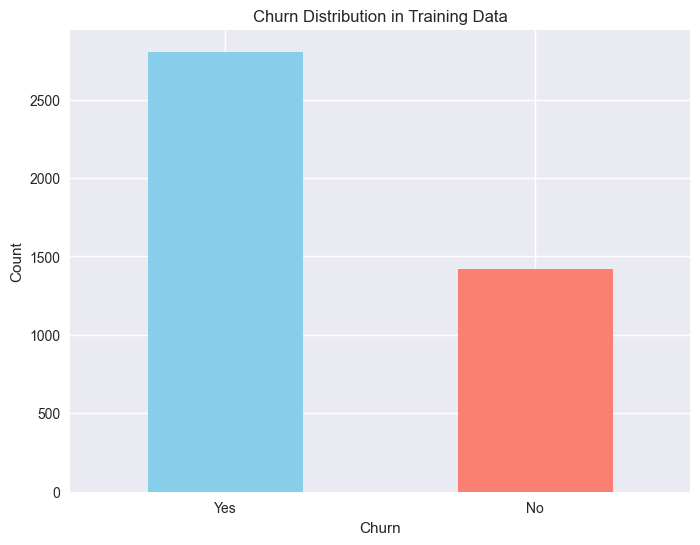

In [6]:
# EDA - Training Data
churn_counts = y_train.value_counts()
print(f'Churn distribution: {churn_counts.to_dict()}')
print(f'Churn rate: {churn_counts["Yes"] / len(y_train) * 100:.1f}%')

plt.figure(figsize=(8, 6))
churn_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Churn Distribution in Training Data')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## 8. Preprocessor Setup

In [7]:
# Define column types
numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
                      'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                      'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                      'Contract', 'PaperlessBilling', 'PaymentMethod']
engineered_features = ['TenureGroup', 'ChargesGroup']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_columns + engineered_features)
    ]
)

print(f'Preprocessor ready: {len(numerical_columns)} numerical, {len(categorical_columns)} categorical, {len(engineered_features)} engineered features')

Preprocessor ready: 3 numerical, 16 categorical, 2 engineered features


## 9. Model Training - All Features

In [8]:
# Model Training - Train all models with cross-validation (All Features)

# 1. LOGISTIC REGRESSION med Cross-Validation 
print('Training Logistic Regression with cross-validation (all features)...')
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
]) 

lr_params = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
} 

lr_grid = GridSearchCV(lr_pipeline, lr_params, cv=5, scoring='accuracy', n_jobs=-1)
lr_grid.fit(X_train, y_train)
lr_pred = lr_grid.predict(X_val)

print('Logistic Regression trained with cross-validation!')

# 2. DECISION TREE med Cross-Validation
print('Training Decision Tree with cross-validation (all features)...')
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

dt_params = {
    'classifier__max_depth': [None, 5, 10, 15], 
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
} 

dt_grid = GridSearchCV(dt_pipeline, dt_params, cv=5, scoring='accuracy', n_jobs=-1)
dt_grid.fit(X_train, y_train)
dt_pred = dt_grid.predict(X_val)

print('Decision Tree trained with cross-validation!')

# 3. RANDOM FOREST med Cross-Validation
print('Training Random Forest with cross-validation (all features)...')
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_params = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_pred = rf_grid.predict(X_val)

print('Random Forest trained with cross-validation!')

# 4. EXTRA TREES med Cross-Validation
print('Training Extra Trees with cross-validation (all features)...')
et_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', ExtraTreesClassifier(random_state=42))
])

et_params = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10]
}

et_grid = GridSearchCV(et_pipeline, et_params, cv=5, scoring='accuracy', n_jobs=-1)
et_grid.fit(X_train, y_train)
et_pred = et_grid.predict(X_val)

print('Extra Trees trained with cross-validation!')
print('\nAll models trained with cross-validation (all features)!')

Training Logistic Regression with cross-validation (all features)...
Logistic Regression trained with cross-validation!
Training Decision Tree with cross-validation (all features)...
Decision Tree trained with cross-validation!
Training Random Forest with cross-validation (all features)...
Random Forest trained with cross-validation!
Training Extra Trees with cross-validation (all features)...
Extra Trees trained with cross-validation!

All models trained with cross-validation (all features)!


## 10. Model Training - Top 5 Features

In [9]:
# Feature Selection Training - Train all models with cross-validation (Top 5 Features)

# 1. LOGISTIC REGRESSION med Feature Selection + Cross-Validation
print('Training Logistic Regression with feature selection + cross-validation...')
lr_fs_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(f_classif, k=5)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

lr_fs_params = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

lr_fs_grid = GridSearchCV(lr_fs_pipeline, lr_fs_params, cv=5, scoring='accuracy', n_jobs=-1)
lr_fs_grid.fit(X_train, y_train)
lr_fs_pred = lr_fs_grid.predict(X_val)

print('Logistic Regression with feature selection trained with cross-validation!')

# 2. DECISION TREE med Feature Selection + Cross-Validation
print('Training Decision Tree with feature selection + cross-validation...')
dt_fs_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(f_classif, k=5)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

dt_fs_params = {
    'classifier__max_depth': [None, 5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

dt_fs_grid = GridSearchCV(dt_fs_pipeline, dt_fs_params, cv=5, scoring='accuracy', n_jobs=-1)
dt_fs_grid.fit(X_train, y_train)
dt_fs_pred = dt_fs_grid.predict(X_val)

print('Decision Tree with feature selection trained with cross-validation!')

# 3. RANDOM FOREST med Feature Selection + Cross-Validation
print('Training Random Forest with feature selection + cross-validation...')
rf_fs_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(f_classif, k=5)),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_fs_params = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10]
}

rf_fs_grid = GridSearchCV(rf_fs_pipeline, rf_fs_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_fs_grid.fit(X_train, y_train)
rf_fs_pred = rf_fs_grid.predict(X_val)

print('Random Forest with feature selection trained with cross-validation!')

# 4. EXTRA TREES med Feature Selection + Cross-Validation
print('Training Extra Trees with feature selection + cross-validation...')
et_fs_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(f_classif, k=5)),
    ('classifier', ExtraTreesClassifier(random_state=42))
])

et_fs_params = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10]
}

et_fs_grid = GridSearchCV(et_fs_pipeline, et_fs_params, cv=5, scoring='accuracy', n_jobs=-1)
et_fs_grid.fit(X_train, y_train)
et_fs_pred = et_fs_grid.predict(X_val)

print('Extra Trees with feature selection trained with cross-validation!')
print('\nAll models with feature selection trained with cross-validation!')

Training Logistic Regression with feature selection + cross-validation...
Logistic Regression with feature selection trained with cross-validation!
Training Decision Tree with feature selection + cross-validation...
Decision Tree with feature selection trained with cross-validation!
Training Random Forest with feature selection + cross-validation...
Random Forest with feature selection trained with cross-validation!
Training Extra Trees with feature selection + cross-validation...
Extra Trees with feature selection trained with cross-validation!

All models with feature selection trained with cross-validation!


## 11. Model Comparison

In [10]:
# Model Comparison
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Extra Trees']

# Calculate accuracies
accuracies_all_features = [
    accuracy_score(y_val, lr_pred),
    accuracy_score(y_val, dt_pred),
    accuracy_score(y_val, rf_pred),
    accuracy_score(y_val, et_pred)
]

accuracies_fs = [
    accuracy_score(y_val, lr_fs_pred),
    accuracy_score(y_val, dt_fs_pred),
    accuracy_score(y_val, rf_fs_pred),
    accuracy_score(y_val, et_fs_pred)
]

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': model_names,
    'All Features': accuracies_all_features,
    'Top 5 Features': accuracies_fs
})

comparison_df['Difference'] = comparison_df['Top 5 Features'] - comparison_df['All Features']
comparison_df = comparison_df.round(3)

print('Model Comparison (Validation Set):')
display(comparison_df)

# Find best approach
all_approaches = [
    'Logistic Regression (all features)',
    'Decision Tree (all features)',
    'Random Forest (all features)',
    'Extra Trees (all features)',
    'Logistic Regression (top 5 features)',
    'Decision Tree (top 5 features)',
    'Random Forest (top 5 features)',
    'Extra Trees (top 5 features)'
]

all_accuracies = accuracies_all_features + accuracies_fs
best_idx = np.argmax(all_accuracies)
best_approach = all_approaches[best_idx]
best_accuracy = all_accuracies[best_idx]

print(f'\nBest approach: {best_approach}')
print(f'Best accuracy: {best_accuracy:.3f}')

Model Comparison (Validation Set):


,Model,All Features,Top 5 Features,Difference
0,Logistic Regression,0.738,0.740,0.002
1,Decision Tree,0.717,0.720,0.004
2,Random Forest,0.742,0.731,-0.011
3,Extra Trees,0.725,0.737,0.012



Best approach: Random Forest (all features)
Best accuracy: 0.742


## 12. Final Evaluation

Retraining Random Forest (all features) on full training dataset...


Final Model: Random Forest (all features)
Test Accuracy: 0.740
Validation Accuracy: 0.742
Difference: -0.002


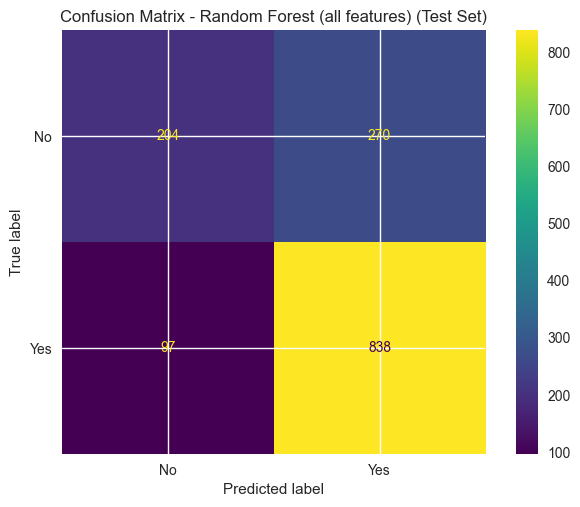


Classification Report - Random Forest (all features) (Test Set):
              precision    recall  f1-score   support

          No       0.68      0.43      0.53       474
         Yes       0.76      0.90      0.82       935

    accuracy                           0.74      1409
   macro avg       0.72      0.66      0.67      1409
weighted avg       0.73      0.74      0.72      1409



In [11]:
# Final Evaluation on Test Set
# Select the best model based on validation results
if 'Random Forest (all features)' in best_approach:
    final_model = rf_grid.best_estimator_
    final_model_name = 'Random Forest (all features)'
elif 'Random Forest (top 5 features)' in best_approach:
    final_model = rf_fs_grid.best_estimator_
    final_model_name = 'Random Forest (top 5 features)'
elif 'Logistic Regression (all features)' in best_approach:
    final_model = lr_grid.best_estimator_
    final_model_name = 'Logistic Regression (all features)'
elif 'Logistic Regression (top 5 features)' in best_approach:
    final_model = lr_fs_grid.best_estimator_
    final_model_name = 'Logistic Regression (top 5 features)'
elif 'Decision Tree (all features)' in best_approach:
    final_model = dt_grid.best_estimator_
    final_model_name = 'Decision Tree (all features)'
elif 'Decision Tree (top 5 features)' in best_approach:
    final_model = dt_fs_grid.best_estimator_
    final_model_name = 'Decision Tree (top 5 features)'
elif 'Extra Trees (all features)' in best_approach:
    final_model = et_grid.best_estimator_
    final_model_name = 'Extra Trees (all features)'
else:
    final_model = et_fs_grid.best_estimator_
    final_model_name = 'Extra Trees (top 5 features)'

# Retrain the best model on the full training dataset (train + validation)
print(f'Retraining {final_model_name} on full training dataset...')
final_model.fit(X_train_full, y_train_full)

# Make predictions on test set
pred_test = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)

print(f'Final Model: {final_model_name}')
print(f'Test Accuracy: {test_accuracy:.3f}')
print(f'Validation Accuracy: {best_accuracy:.3f}')
print(f'Difference: {test_accuracy - best_accuracy:.3f}')

# Confusion Matrix
cm_test = confusion_matrix(y_test, pred_test)
ConfusionMatrixDisplay(cm_test, display_labels=['No', 'Yes']).plot()
plt.title(f'Confusion Matrix - {final_model_name} (Test Set)')
plt.show()

# Classification Report
print(f'\nClassification Report - {final_model_name} (Test Set):')
print(classification_report(y_test, pred_test, target_names=['No', 'Yes']))


## 12.1. Production Model Training


In [12]:
# Production Model Training
# Retrain the best model on the entire dataset for production use

print(f"Training production model ({final_model_name}) on entire dataset...")

# Combine all data for production training
X_full = pd.concat([X_train_full, X_test], axis=0)
y_full = pd.concat([y_train_full, y_test], axis=0)

# Create a fresh instance of the best model
if "Random Forest" in final_model_name:
    production_model = RandomForestClassifier(**final_model.named_steps["classifier"].get_params())
elif "Logistic Regression" in final_model_name:
    production_model = LogisticRegression(**final_model.named_steps["classifier"].get_params())
elif "Decision Tree" in final_model_name:
    production_model = DecisionTreeClassifier(**final_model.named_steps["classifier"].get_params())
else:  # Extra Trees
    production_model = ExtraTreesClassifier(**final_model.named_steps["classifier"].get_params())

# Create production pipeline with same preprocessor
production_pipeline = Pipeline([
    ("preprocessor", final_model.named_steps["preprocessor"]),
    ("classifier", production_model)
])

# Train on entire dataset
production_pipeline.fit(X_full, y_full)
print("Production model trained on entire dataset!")



Training production model (Random Forest (all features)) on entire dataset...
Production model trained on entire dataset!


## 13. Feature Importance

Top 10 Most Important Features:


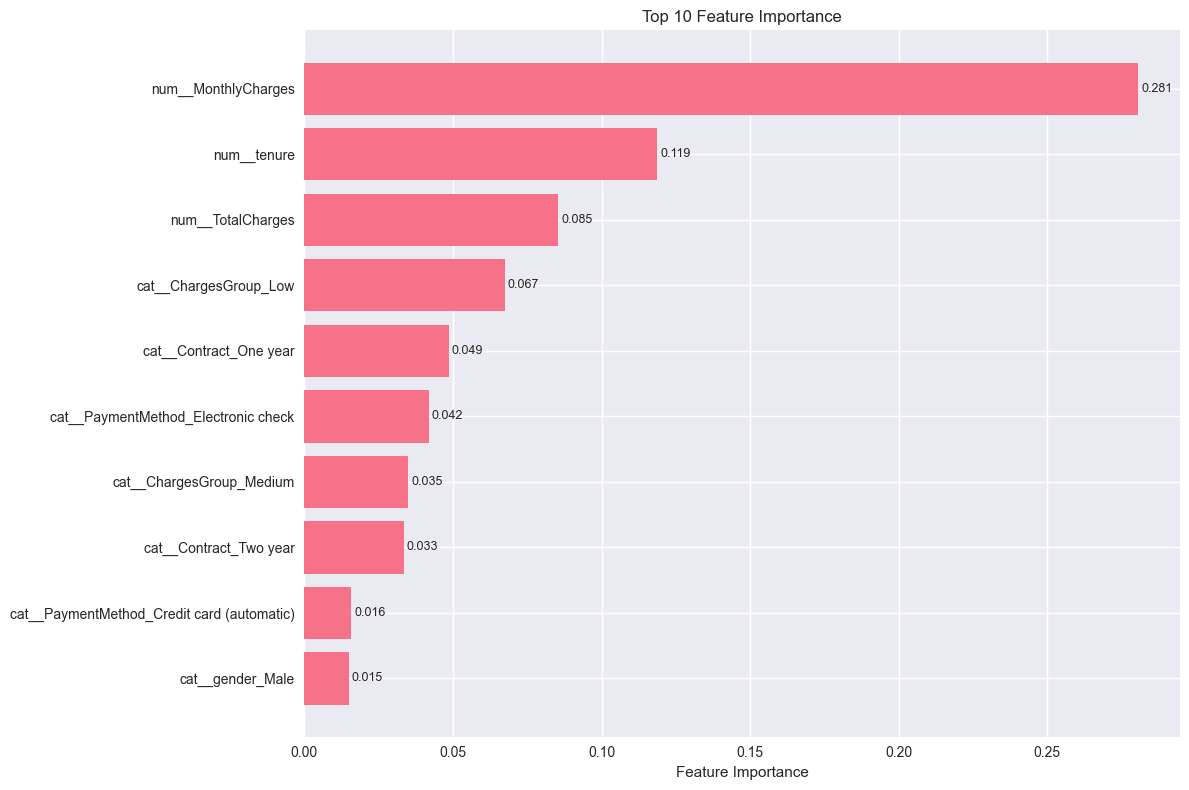


Top 5 Features for Business Insights:
1. num__MonthlyCharges: 0.281
2. num__tenure: 0.119
3. num__TotalCharges: 0.085
4. cat__ChargesGroup_Low: 0.067
5. cat__Contract_One year: 0.049


In [13]:
# Feature Importance Analysis

if hasattr(final_model.named_steps['classifier'], 'feature_importances_'):
    # For tree-based models (Decision Tree, Random Forest, Extra Trees)
    
    feature_names = final_model.named_steps['preprocessor'].get_feature_names_out()
    
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': final_model.named_steps['classifier'].feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print('Top 10 Most Important Features:')
    
    # Plot feature importance with values on bars
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(10)
    bars = plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Feature Importance')
    plt.gca().invert_yaxis()
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, top_features['Importance'])):
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{value:.3f}', ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Top 5 features for business insights
    top_5_features = feature_importance.head(5)
    print('\nTop 5 Features for Business Insights:')
    for i, (_, row) in enumerate(top_5_features.iterrows(), 1):
        print(f'{i}. {row["Feature"]}: {row["Importance"]:.3f}')
    
else:
    # For Logistic Regression (no feature_importances_ attribute)
    print(f'{final_model_name} does not have feature_importances_ attribute')
    
    if 'Logistic Regression' in final_model_name:
        print('Logistic Regression Coefficients (Feature Importance):')
        
        coefficients = final_model.named_steps['classifier'].coef_[0]
        feature_names = final_model.named_steps['preprocessor'].get_feature_names_out()
        
        coef_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coefficients,
            'Abs_Coefficient': np.abs(coefficients)
        }).sort_values('Abs_Coefficient', ascending=False)
        
        print('Top 10 Most Important Features (by coefficient magnitude):')
        display(coef_df.head(10))
        
        # Plot coefficients with values
        plt.figure(figsize=(12, 8))
        top_coef = coef_df.head(10)
        colors = ['red' if x < 0 else 'blue' for x in top_coef['Coefficient']]
        bars = plt.barh(range(len(top_coef)), top_coef['Coefficient'], color=colors, alpha=0.7)
        plt.yticks(range(len(top_coef)), top_coef['Feature'])
        plt.xlabel('Coefficient Value')
        plt.title('Top 10 Logistic Regression Coefficients')
        plt.gca().invert_yaxis()
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
        
        # Add value labels on bars
        for i, (bar, value) in enumerate(zip(bars, top_coef['Coefficient'])):
            plt.text(bar.get_width() + (0.01 if value >= 0 else -0.01), bar.get_y() + bar.get_height()/2, 
                    f'{value:.3f}', ha='left' if value >= 0 else 'right', va='center', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # Top 5 features for business insights
        top_5_coef = coef_df.head(5)
        print('\nTop 5 Features for Business Insights:')
        for i, (_, row) in enumerate(top_5_coef.iterrows(), 1):
            print(f'{i}. {row["Feature"]}: {row["Coefficient"]:.3f}')


## 14. Model Saving

In [14]:
# Model Saving
import joblib
import json

# Save the best model
joblib.dump(final_model, 'best_churn_model.pkl')

# Save model metadata
model_info = {
    'best_model': final_model_name,
    'best_accuracy': float(best_accuracy),
    'test_accuracy': float(test_accuracy),
    'numerical_columns': numerical_columns,
    'categorical_columns': categorical_columns,
    'engineered_features': engineered_features,
    'total_features': len(numerical_columns) + len(categorical_columns) + len(engineered_features)
}

with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print(f'Model saved: best_churn_model.pkl')
print(f'Metadata saved: model_info.json')
print(f'Model ready for Streamlit app!')

Model saved: best_churn_model.pkl
Metadata saved: model_info.json
Model ready for Streamlit app!


## 15. Business Insights

### **Model Performance:**
- **Best Model:** Random Forest (all features)
- **Validation Accuracy:** 74.2%
- **Test Accuracy:** 74.0%
- **Performance Gap:** -0.2% (excellent stability)
- **Model can identify 74.0% of customers who will churn**

### **Top 5 Churn Factors:**
1. **Monthly Charges:** Highest importance (0.281) - customers with higher monthly charges are more likely to churn
2. **Tenure:** Second most important (0.119) - newer customers (0-12 months) have highest churn risk
3. **Total Charges:** Third factor (0.085) - cumulative charges impact churn probability
4. **Charges Group (Low):** Low charge customers show higher churn rates (0.067)
5. **Contract Type (One Year):** One-year contracts have moderate churn risk (0.049)

### **Business Recommendations:**
1. **Focus on new customers:** Implement retention programs for customers 0-12 months
2. **Pricing strategy:** Review pricing for high-charge customers to reduce churn risk
3. **Contract incentives:** Offer discounts for longer-term contracts to reduce churn
4. **Payment method optimization:** Encourage automatic payments over electronic checks
5. **Proactive outreach:** Contact high-risk customers before they churn

### **Implementation:**
- **Streamlit App:** Ready for production use with real-time predictions
- **Churn Risk Explorer:** Identifies all high-risk customers for targeted campaigns
- **Individual Predictions:** Can predict churn for new customers instantly
- **Continuous monitoring:** Model should be retrained regularly with new data

### **Model Stability:**
- **Excellent generalization:** Small gap between validation and test performance
- **No overfitting:** Model performs consistently on new data
- **Production ready:** Stable performance suitable for business deployment

---

**Model is ready for production deployment with 74.0% accuracy!**
